In [211]:
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

## 1) Coletando dados ficticios

In [212]:
# Especifique o caminho para o arquivo CSV
caminho_arquivo_csv = "../Dados/alunos_vet_ficticios.csv"

# Carregue o arquivo CSV em um DataFrame
df = pd.read_csv(caminho_arquivo_csv)

df

,Media_Total,Coeficiente,Introducao_a_Programacao,Estrutura_de_Dados,Introducao_a_Programacao_Aprovado,Estrutura_de_Dados_Aprovado,Desempenho
0,6.748437,6.623780,2.291808,1.492419,0,0,Médio
1,8.842322,9.331187,9.554135,7.201338,1,1,Bem
2,8.567444,8.323023,2.959294,5.498499,0,0,Bem
3,7.393484,6.675646,9.388512,0.209364,1,0,Mal
4,6.836498,7.064244,7.004154,6.315824,1,1,Médio
...,...,...,...,...,...,...,...
995,5.935026,7.068823,0.049197,9.188964,0,1,Mal
996,9.310145,10.839681,0.658848,4.370339,0,0,Médio
997,8.138169,6.910574,2.779150,0.547032,0,0,Mal
998,9.467479,11.189241,8.005626,6.981398,1,1,Bem


### 1.1) Dividir os dados em recursos (X) e rótulos (y)

In [213]:
X = df[['Media_Total', 'Coeficiente', 'Introducao_a_Programacao', 'Estrutura_de_Dados', 'Introducao_a_Programacao_Aprovado', 'Estrutura_de_Dados_Aprovado']]
y = df['Desempenho']

## 2) Pré-processando dados

In [214]:
# Codificar as classes de desempenho em valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## 3) Divisão em dados de treinamento e teste

In [215]:
X_train, X_temp, y_train, y_temp  = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Padronizar as características (normalização)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Converter as classes em vetores one-hot (para a camada de saída)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## 4) Experimentando diferentes redes neurais

In [216]:
architectures = [
    (32, 32),        # Exemplo de arquitetura 1
    (64, 32, 16),    # Exemplo de arquitetura 2
    (128, 64),       # Exemplo de arquitetura 3
]

best_model = None
best_accuracy = 0.0
min_loss = 100

accuracies_train = []  # Lista para armazenar acurácias de treinamento
accuracies_test = []  # Lista para armazenar acurácias de teste

### 4.1) Construindo redes neurais

In [217]:
for architecture in architectures:
    model = Sequential()
    for units in architecture:
        model.add(Dense(units, activation='relu', input_dim=X.columns.shape[0]))
    model.add(Dense(3, activation='softmax'))  # 3 unidades na camada de saída para as três classes
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    train_accuracy = [acc * 100 for acc in history.history['accuracy']]
    _, test_accuracy = model.evaluate(X_test, y_test)
    accuracies_train.append(train_accuracy)
    accuracies_test.append(test_accuracy)

    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'Arquitetura {architecture}: Acurácia na validação: {accuracy * 100:.2f}%')
    print(f'Arquitetura {architecture}: Loss final: {loss * 100:.2f}%')
    print("----------------------------------------------------------------\n")

    if accuracy > best_accuracy and loss < min_loss:
        best_accuracy = accuracy
        best_model = model


5/5 [==============================] - 0s 1ms/step - loss: 0.2162 - accuracy: 0.8933
Arquitetura (32, 32): Acurácia na validação: 89.33%
Arquitetura (32, 32): Loss final: 21.62%
----------------------------------------------------------------

5/5 [==============================] - 0s 1ms/step - loss: 0.1525 - accuracy: 0.9200
Arquitetura (64, 32, 16): Acurácia na validação: 92.00%
Arquitetura (64, 32, 16): Loss final: 15.25%
----------------------------------------------------------------

5/5 [==============================] - 0s 1ms/step - loss: 0.1536 - accuracy: 0.9200
Arquitetura (128, 64): Acurácia na validação: 92.00%
Arquitetura (128, 64): Loss final: 15.36%
----------------------------------------------------------------



### 4.2) Plotando Diferenças

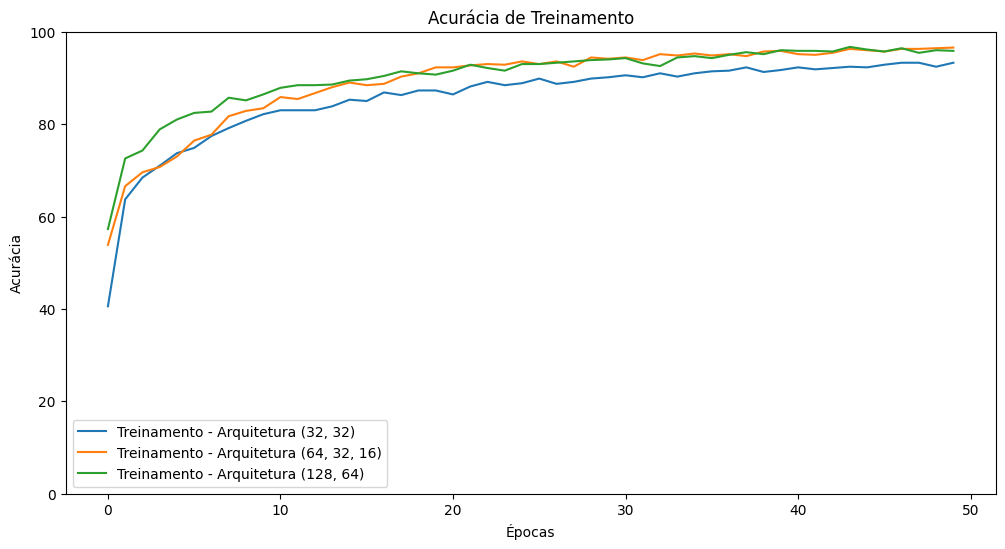

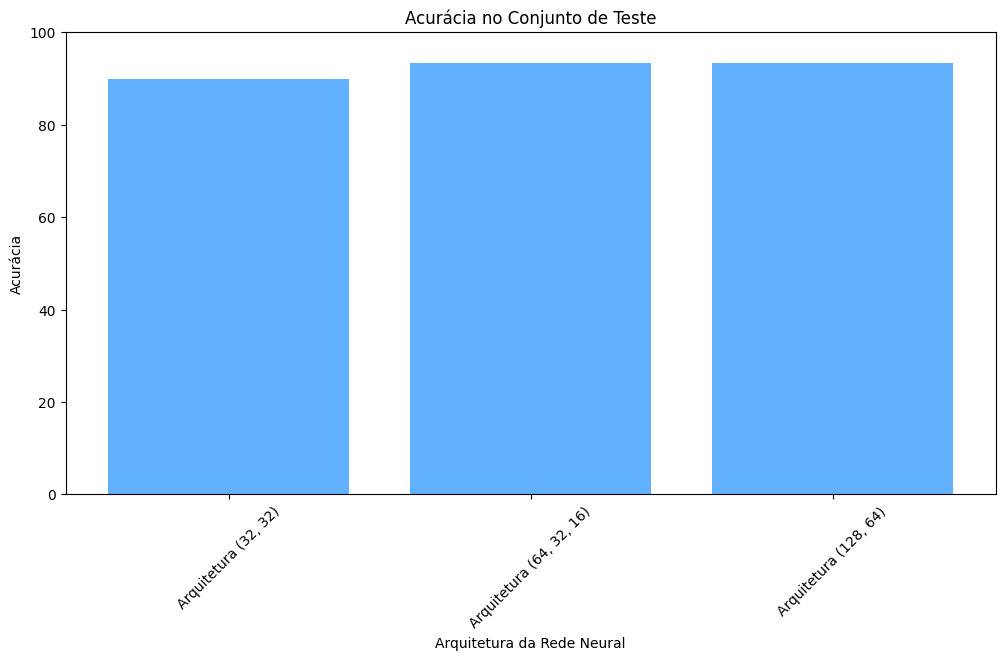

In [218]:
# Plotar os resultados
plt.figure(figsize=(12, 6))

# Gráfico de linhas para a acurácia de treinamento
for i, architecture in enumerate(architectures):
    plt.plot(accuracies_train[i], label=f'Treinamento - Arquitetura {architecture}')

plt.title('Acurácia de Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Definir os limites do eixo y para variar de 0 a 100
plt.ylim(0, 100)

# Criar um gráfico de barras separado para a acurácia no teste
plt.figure(figsize=(12, 6))
test_accuracies = [accuracy * 100 for accuracy in accuracies_test]
architecture_labels = [f'Arquitetura {architecture}' for architecture in architectures]

plt.bar(architecture_labels, test_accuracies, color='dodgerblue', alpha=0.7)
plt.title('Acurácia no Conjunto de Teste')
plt.xlabel('Arquitetura da Rede Neural')
plt.ylabel('Acurácia')
plt.ylim(0, 100)  # Definir os limites do eixo y para variar de 0 a 100
plt.xticks(rotation=45)

plt.show()

### 4.3) Avaliando 

In [219]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Melhor modelo - Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

5/5 [==============================] - 0s 1ms/step - loss: 0.2047 - accuracy: 0.9333
Melhor modelo - Acurácia no conjunto de teste: 93.33%


## 5) Predição do melhor modelo

In [220]:
y_pred = best_model.predict(X_test)

5/5 [==============================] - 0s 1000us/step


## 6) Matriz Confusão

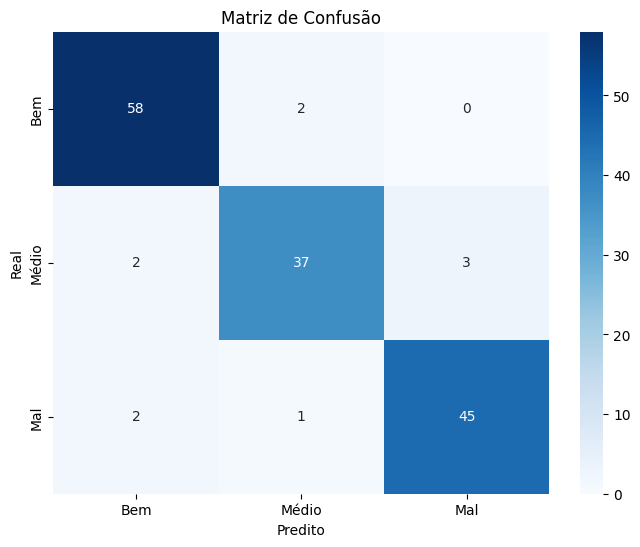

In [221]:
# Calcule a matriz de confusão
# Transformar as previsões de volta para as classes originais
y_pred_classes = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_classes = label_encoder.inverse_transform(np.argmax(y_test, axis=1))


cm = confusion_matrix(y_test_classes, y_pred_classes)  # Substitua y_test e y_pred pelos seus dados reais e previstos

# Crie uma visualização da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bem', 'Médio', 'Mal'], yticklabels=['Bem', 'Médio', 'Mal'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## 7) Métricas de eficácia

In [222]:
print("----------------------------------------------------------------")
accuracy = accuracy_score(y_test_classes, y_pred_classes)  
print(f'Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

print("----------------------------------------------------------------\n")
classification_rep = classification_report(y_test_classes, y_pred_classes)
print(f'Relatório de Classificação:\n{classification_rep}')


# precision = precision_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Precisão: {precision}')

# recall = recall_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Recall: {recall}')

# f1 = f1_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Medida F: {f1}')

----------------------------------------------------------------
Acurácia no conjunto de teste: 93.33%
----------------------------------------------------------------

Relatório de Classificação:
              precision    recall  f1-score   support

         Bem       0.94      0.97      0.95        60
         Mal       0.93      0.88      0.90        42
       Médio       0.94      0.94      0.94        48

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



## A) OBS: Rede Neural Unica

In [227]:
# Construir um modelo de rede neural
neuralNetwork = Sequential()
neuralNetwork.add(Dense(64, input_dim=X.columns.shape[0], activation='relu'))
neuralNetwork.add(Dense(32, activation='relu'))
neuralNetwork.add(Dense(3, activation='softmax'))  # 3 unidades na camada de saída para as três classes

neuralNetwork.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

neuralNetwork.fit(X_train, y_train, epochs=100, batch_size=32)

y_pred = neuralNetwork.predict(X_test)

test_loss, test_accuracy = neuralNetwork.evaluate(X_test, y_test)
print(f'Melhor modelo - Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

Epoch 1/100
22/22 [==============================] - 0s 905us/step - loss: 1.0787 - accuracy: 0.4671
Epoch 2/100
22/22 [==============================] - 0s 905us/step - loss: 0.8653 - accuracy: 0.6500
Epoch 3/100
22/22 [==============================] - 0s 905us/step - loss: 0.7591 - accuracy: 0.6871
Epoch 4/100
22/22 [==============================] - 0s 809us/step - loss: 0.6827 - accuracy: 0.7243
Epoch 5/100
22/22 [==============================] - 0s 857us/step - loss: 0.6293 - accuracy: 0.7529
Epoch 6/100
22/22 [==============================] - 0s 857us/step - loss: 0.5846 - accuracy: 0.7771
Epoch 7/100
22/22 [==============================] - 0s 857us/step - loss: 0.5456 - accuracy: 0.7857
Epoch 8/100
22/22 [==============================] - 0s 810us/step - loss: 0.5114 - accuracy: 0.8129
Epoch 9/100
22/22 [==============================] - 0s 857us/step - loss: 0.4796 - accuracy: 0.8314
Epoch 10/100
22/22 [==============================] - 0s 809us/step - loss: 0.4550 - accura

## A.1) Matriz Confusão

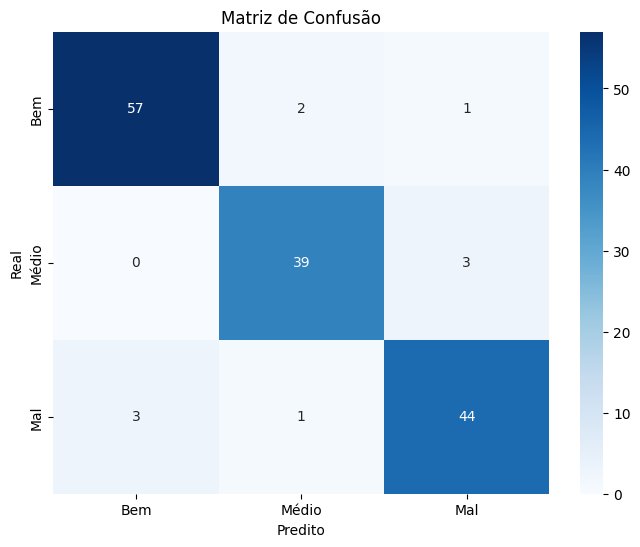

In [228]:
# Calcule a matriz de confusão
# Transformar as previsões de volta para as classes originais
y_pred_classes = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_classes = label_encoder.inverse_transform(np.argmax(y_test, axis=1))


cm = confusion_matrix(y_test_classes, y_pred_classes)  # Substitua y_test e y_pred pelos seus dados reais e previstos

# Crie uma visualização da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bem', 'Médio', 'Mal'], yticklabels=['Bem', 'Médio', 'Mal'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## A.2) Métricas de eficácia

In [229]:
print("----------------------------------------------------------------")
accuracy = accuracy_score(y_test_classes, y_pred_classes)  
print(f'Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

print("----------------------------------------------------------------\n")
classification_rep = classification_report(y_test_classes, y_pred_classes)
print(f'Relatório de Classificação:\n{classification_rep}')


# precision = precision_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Precisão: {precision}')

# recall = recall_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Recall: {recall}')

# f1 = f1_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Medida F: {f1}')

----------------------------------------------------------------
Acurácia no conjunto de teste: 93.33%
----------------------------------------------------------------

Relatório de Classificação:
              precision    recall  f1-score   support

         Bem       0.95      0.95      0.95        60
         Mal       0.93      0.93      0.93        42
       Médio       0.92      0.92      0.92        48

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150

